In [1]:
from clickhouse_connect import get_client

In [2]:
import json

# Read the factor weights from the JSON file
with open('factor_weights_tickers.json', 'r') as f:
    factor_weights = json.load(f)

    # Get all unique tickers from all factors
    all_tickers = set()
    for factor_name, ticker_weights in factor_weights.items():
        all_tickers.update(ticker_weights.keys())
    
    # Convert to sorted list for consistent ordering
    all_tickers = sorted(list(all_tickers))
    
    # Create DataFrame with tickers as index
    import pandas as pd
    facs = pd.DataFrame(index=all_tickers)
    facs.index.name = 'ticker'
    
    # Add columns for each factor with their respective weights
    for factor_name in factor_weights.keys():
        facs[factor_name] = facs.index.map(factor_weights[factor_name]).fillna(0)
    
    print(f"Created DataFrame with {len(facs)} unique tickers and {len(factor_weights)} factors")
    print(f"Factors: {list(factor_weights.keys())}")

facs

Created DataFrame with 3240 unique tickers and 5 factors
Factors: ['HML', 'SMB', 'RMW', 'CMA', 'MKT-RF']


,HML,SMB,RMW,CMA,MKT-RF
ticker,,,,,
A,-1.147855e-03,-0.000754,0.000000e+00,0.000000e+00,7.225383e-04
AA,1.534279e-03,-0.000228,-1.339773e-03,6.590737e-04,2.186320e-04
AADI,7.376813e-06,0.000025,-6.441626e-06,3.168826e-06,1.051183e-06
AAME,3.966090e-06,0.000013,-3.463294e-06,0.000000e+00,5.651608e-07
AAOI,-5.380184e-05,0.000807,-2.075335e-04,1.020918e-04,3.386654e-05
...,...,...,...,...,...
ZVRA,-1.441956e-05,0.000216,-5.562157e-05,-2.246978e-05,9.076657e-06
ZVSA,3.219662e-07,0.000001,-2.811493e-07,1.383056e-07,4.587961e-08
ZWS,0.000000e+00,-0.000129,-7.548046e-04,3.713106e-04,1.231735e-04


In [ ]:
factor_weights.keys()
dict_keys(['HML', 'SMB', 'RMW', 'CMA', 'MKT-RF'])
factor_weights['HML']
{'FKWL': 6.47584425835353e-06,
 'INDB': 0.00039344571116322865,
 'DSS': 9.219855375987306e-07,
 'SKYW': 0.0005918482606140543,
 'ADM': 0.003341906448337647,
 'FNB': 0.0007887797356421947,
 'FCNCA': 0.0038113606191324916,
 'WBS': 0.0013544809599668644,
 'MKL': 0.0029331157881417763,
 'FLIC': 4.172423209168617e-05,
 'AVD': 2.2129663575097385e-05,
 'CRMT': 4.8726642886655634e-05,
 'CATO': 7.660133564785045e-06,
 'WSBC': 0.00030227324130056073,
 'UBSI': 0.0007310751550757348,

dict_keys(['HML', 'SMB', 'RMW', 'CMA', 'MKT-RF'])

In [3]:
# Create a properly formatted string for the SQL IN clause
ticker_list_str = "(" + ",".join([f"'{ticker}'" for ticker in facs.index]) + ")"

In [4]:
from clickhouse_connect import get_client
client = get_client()
df = client.query_df(f"""
SELECT
    ticker,
    toDate(fromUnixTimestamp64Nano(window_start)) as date,
    close,
    FROM s3('https://files.polygon.io/flatfiles/us_stocks_sip/day_aggs_v1/2024/*/*.csv.gz')
WHERE ticker IN {ticker_list_str} AND date >= '2024-06-25'
SETTINGS max_threads=16, max_threads=16
""")

In [5]:
import numpy as np
# Pivot the DataFrame to have dates as rows, tickers as columns, and close prices as values
df_pivoted = df.pivot(index='date', columns='ticker', values='close')
rets = np.log(df_pivoted).diff()[1:]
rets

ticker,A,AA,AADI,AAME,AAOI,AAON,AAP,AAPL,ABAT,ABBV,...,ZS,ZTS,ZUMZ,ZUO,ZVIA,ZVRA,ZVSA,ZWS,ZYME,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2024-06-26,-0.011950,-0.012851,-0.060625,0.000000,-0.009357,0.001886,-0.030286,0.019796,0.060064,0.002340,...,-0.019921,0.017234,-0.002065,0.005432,0.076693,0.012987,0.052138,-0.017652,0.004773,0.034172
2024-06-27,-0.017356,-0.015591,0.018576,0.035507,0.001174,0.020518,0.014620,0.003978,0.056660,-0.012701,...,0.055866,0.032016,0.002581,0.041385,0.086239,0.033830,-0.032612,-0.001371,0.001190,0.011136
2024-06-28,-0.008985,0.024429,-0.110144,-0.017596,-0.027366,0.006671,0.009998,-0.016388,0.057629,0.014860,...,0.015680,-0.017724,0.004115,0.031716,-0.184615,0.018538,0.037945,0.008197,0.011820,0.031610
2024-07-01,-0.017352,-0.002013,-0.027780,0.001596,-0.025658,-0.042859,-0.058860,0.028689,-0.074724,-0.006727,...,0.032909,-0.004509,-0.039262,-0.020347,0.016014,-0.082938,-0.040074,-0.022009,0.011682,-0.043867
2024-07-02,-0.012797,0.028066,-0.073025,-0.068900,-0.022529,0.026215,0.014795,0.016109,-0.053110,-0.026226,...,-0.009917,0.012839,0.006917,-0.013451,-0.038784,-0.033825,-0.023047,0.014498,-0.024693,0.016676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011082,0.000777,0.047791,-0.016695,0.081048,0.001865,-0.000457,0.011413,0.378898,0.008985,...,0.007074,0.002553,-0.013266,0.001009,0.055979,0.001165,-0.017242,0.009031,-0.009852,-0.018417
2024-12-26,-0.001986,-0.006757,0.032790,0.007848,0.027738,-0.006176,0.011595,0.003171,0.188711,-0.004454,...,0.001974,0.004966,0.058612,0.001008,0.087727,-0.003499,0.067252,0.006063,0.025141,0.030509
2024-12-27,-0.002137,-0.017625,0.034869,-0.008319,-0.081387,-0.010324,-0.004077,-0.013331,0.067718,-0.006663,...,-0.016497,-0.005574,-0.019329,-0.001008,-0.018544,-0.020060,-0.067252,-0.008976,0.000000,-0.013309


In [6]:
# Align the dataframes - keep only stocks that exist in both
common_stocks = facs.index.intersection(rets.columns)
common_stocks
# Subset both dataframes to common stocks
facs_aligned = facs.loc[common_stocks]
rets_aligned = rets[common_stocks]

# Compute factor returns: dot product of returns with factor weights
# For each date (row in rets), compute dot product with each factor (column in facs)
fac_returns = rets_aligned.ffill().fillna(0) @ facs_aligned

# Result: DataFrame with dates as index and factors (HML, SMB, RMW, CMA) as columns
fac_returns

,HML,SMB,RMW,CMA,MKT-RF
date,,,,,
2024-06-26,0.000694,0.004540,-8.383000e-03,0.013904,-0.003496
2024-06-27,-0.000630,0.006910,-6.523864e-03,-0.010127,0.001909
2024-06-28,0.014333,0.011602,-8.516252e-03,0.000579,-0.002398
2024-07-01,-0.007871,-0.013738,9.867638e-03,-0.001526,0.002964
2024-07-02,-0.002311,-0.005201,3.004007e-03,-0.007228,0.006398
...,...,...,...,...,...
2024-12-24,-0.002971,-0.000769,1.663881e-04,-0.003638,0.010715
2024-12-26,0.002641,0.011138,-4.885561e-07,0.004604,0.000183
2024-12-27,0.007677,-0.004887,7.780140e-04,0.001505,-0.011341


In [7]:
import sqlite3
tidy_finance = sqlite3.connect(database="data/tidy_finance_python.sqlite")
# Load original FF5 factors for comparison
factors_ff5_daily = pd.read_sql_query(
    sql="SELECT date, smb, hml, rmw, cma FROM factors_ff5_daily",
    con=tidy_finance,
    parse_dates={"date"},
)

# Rename replicated factors with suffix and make FF5 factors lowercase
fac_returns_renamed = fac_returns.rename(columns={col: col.lower() + '_replicated' for col in fac_returns.columns})
factors_ff5_daily.columns = [col.lower() if col != 'date' else col for col in factors_ff5_daily.columns]

factors_replicated = fac_returns_renamed.merge(factors_ff5_daily, how="inner", on="date").round(4)

print(f"\nEvaluation sample: {len(factors_replicated)} overlapping days")



Evaluation sample: 131 overlapping days


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    smb   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     1257.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           2.31e-68
Time:                        05:55:04   Log-Likelihood:                 591.05
No. Observations:                 131   AIC:                            -1178.
Df Residuals:                     129   BIC:                            -1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0004      0.000     -1.793      0.075      -0.001    4.37e-05
smb_replicated     0.7982      0.023     35.448      0.000       0.754       0.843
==============================================================================
Omnibus:                      184.860   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12638.307
Skew:                          -5.315   Prob(JB):                         0.00
Kurtosis:                      49.930   Cond. No.                         96.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hml   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     358.1
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           4.91e-39
Time:                        05:55:04   Log-Likelihood:                 528.69
No. Observations:                 131   AIC:                            -1053.
Df Residuals:                     129   BIC:                            -1048.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0003      0.000     -0.815      0.417      -0.001       0.000
hml_replicated     0.6167      0.033     18.925      0.000       0.552       0.681
==============================================================================
Omnibus:                       75.873   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1104.082
Skew:                          -1.565   Prob(JB):                    1.79e-240
Kurtosis:                      16.874   Cond. No.                         86.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rmw   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     32.67
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           7.19e-08
Time:                        05:55:04   Log-Likelihood:                 522.23
No. Observations:                 131   AIC:                            -1040.
Df Residuals:                     129   BIC:                            -1035.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0002      0.000      0.406      0.685      -0.001       0.001
rmw_replicated     0.2520      0.044      5.716      0.000       0.165       0.339
==============================================================================
Omnibus:                        2.996   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.978
Skew:                           0.106   Prob(JB):                        0.226
Kurtosis:                       3.708   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cma   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     52.82
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           3.11e-11
Time:                        05:55:04   Log-Likelihood:                 538.67
No. Observations:                 131   AIC:                            -1073.
Df Residuals:                     129   BIC:                            -1068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -6.761e-06      0.000     -0.019      0.985      -0.001       0.001
cma_replicated     0.2382      0.033      7.268      0.000       0.173       0.303
==============================================================================
Omnibus:                       25.536   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.138
Skew:                           0.710   Prob(JB):                     1.60e-15
Kurtosis:                       6.236   Cond. No.                         94.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

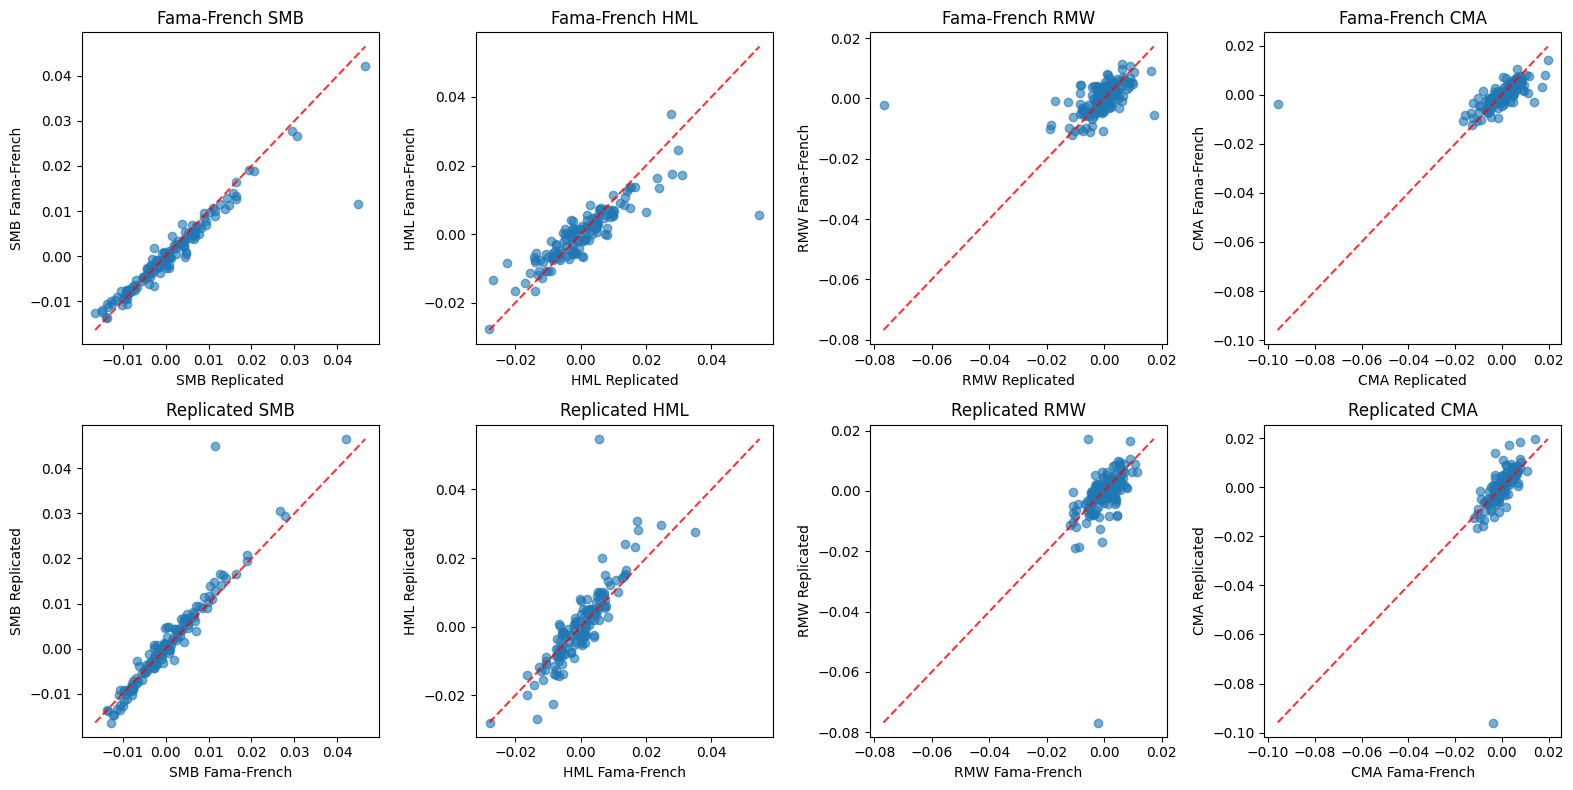

In [8]:
import statsmodels.formula.api as smf
model_smb = smf.ols(formula="smb ~ smb_replicated", data=factors_replicated).fit()
display(model_smb.summary())
model_hml = smf.ols(formula="hml ~ hml_replicated", data=factors_replicated).fit()
display(model_hml.summary())
model_rmw = smf.ols(formula="rmw ~ rmw_replicated", data=factors_replicated).fit()
display(model_rmw.summary())
model_cma = smf.ols(formula="cma ~ cma_replicated", data=factors_replicated).fit()
display(model_cma.summary())

import matplotlib.pyplot as plt
import numpy as np

# Create a 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Factor names and labels
factors = ['smb', 'hml', 'rmw', 'cma']
factor_labels = ['SMB', 'HML', 'RMW', 'CMA']

for i, (factor, label) in enumerate(zip(factors, factor_labels)):
    # Top row: Fama-French original factors
    axes[0, i].scatter(factors_replicated[f'{factor}_replicated'], factors_replicated[factor], alpha=0.6)
    axes[0, i].set_xlabel(f'{label} Replicated')
    axes[0, i].set_ylabel(f'{label} Fama-French')
    axes[0, i].set_title(f'Fama-French {label}')
    
    # Add diagonal line for reference
    min_val = min(factors_replicated[factor].min(), factors_replicated[f'{factor}_replicated'].min())
    max_val = max(factors_replicated[factor].max(), factors_replicated[f'{factor}_replicated'].max())
    axes[0, i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    # Bottom row: My replicated factors
    axes[1, i].scatter(factors_replicated[factor], factors_replicated[f'{factor}_replicated'], alpha=0.6)
    axes[1, i].set_xlabel(f'{label} Fama-French')
    axes[1, i].set_ylabel(f'{label} Replicated')
    axes[1, i].set_title(f'Replicated {label}')
    
    # Add diagonal line for reference
    axes[1, i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

plt.tight_layout()
plt.show()

WMT regression sample: 131 observations

=== WMT Regression on Replicated Factors ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             wmt_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.667
Date:                Tue, 30 Sep 2025   Prob (F-statistic):             0.0353
Time:                        05:55:05   Log-Likelihood:                 404.33
No. Observations:                 131   AIC:                            -798.7
Df Residuals:                     126   BIC:                            -784.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0023      0.001      2.341      0.021       0.000       0.004
hml_replicated    -0.2882      0.110     -2.631      0.010      -0.505      -0.071
smb_replicated     0.2085      0.143      1.462      0.146      -0.074       0.491
rmw_replicated     0.1956      0.188      1.043      0.299      -0.175       0.567
cma_replicated    -0.2747      0.121     -2.272      0.025      -0.514      -0.035
==============================================================================
Omnibus:                       31.336   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.734
Skew:                           0.792   Prob(JB):                     4.03e-24
Kurtosis:                       7.151   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


=== WMT Regression on Fama-French Factors ===


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             wmt_return   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     4.172
Date:                Tue, 30 Sep 2025   Prob (F-statistic):            0.00331
Time:                        05:55:05   Log-Likelihood:                 407.15
No. Observations:                 131   AIC:                            -804.3
Df Residuals:                     126   BIC:                            -789.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.001      2.231      0.027       0.000       0.004
hml           -0.3047      0.149     -2.044      0.043      -0.600      -0.010
smb            0.0073      0.159      0.046      0.963      -0.307       0.322
rmw           -0.3235      0.253     -1.278      0.204      -0.825       0.178
cma           -0.6502      0.211     -3.076      0.003      -1.069      -0.232
==============================================================================
Omnibus:                       48.344   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.920
Skew:                           1.170   Prob(JB):                     9.72e-52
Kurtosis:                       9.129   Cond. No.                         304.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

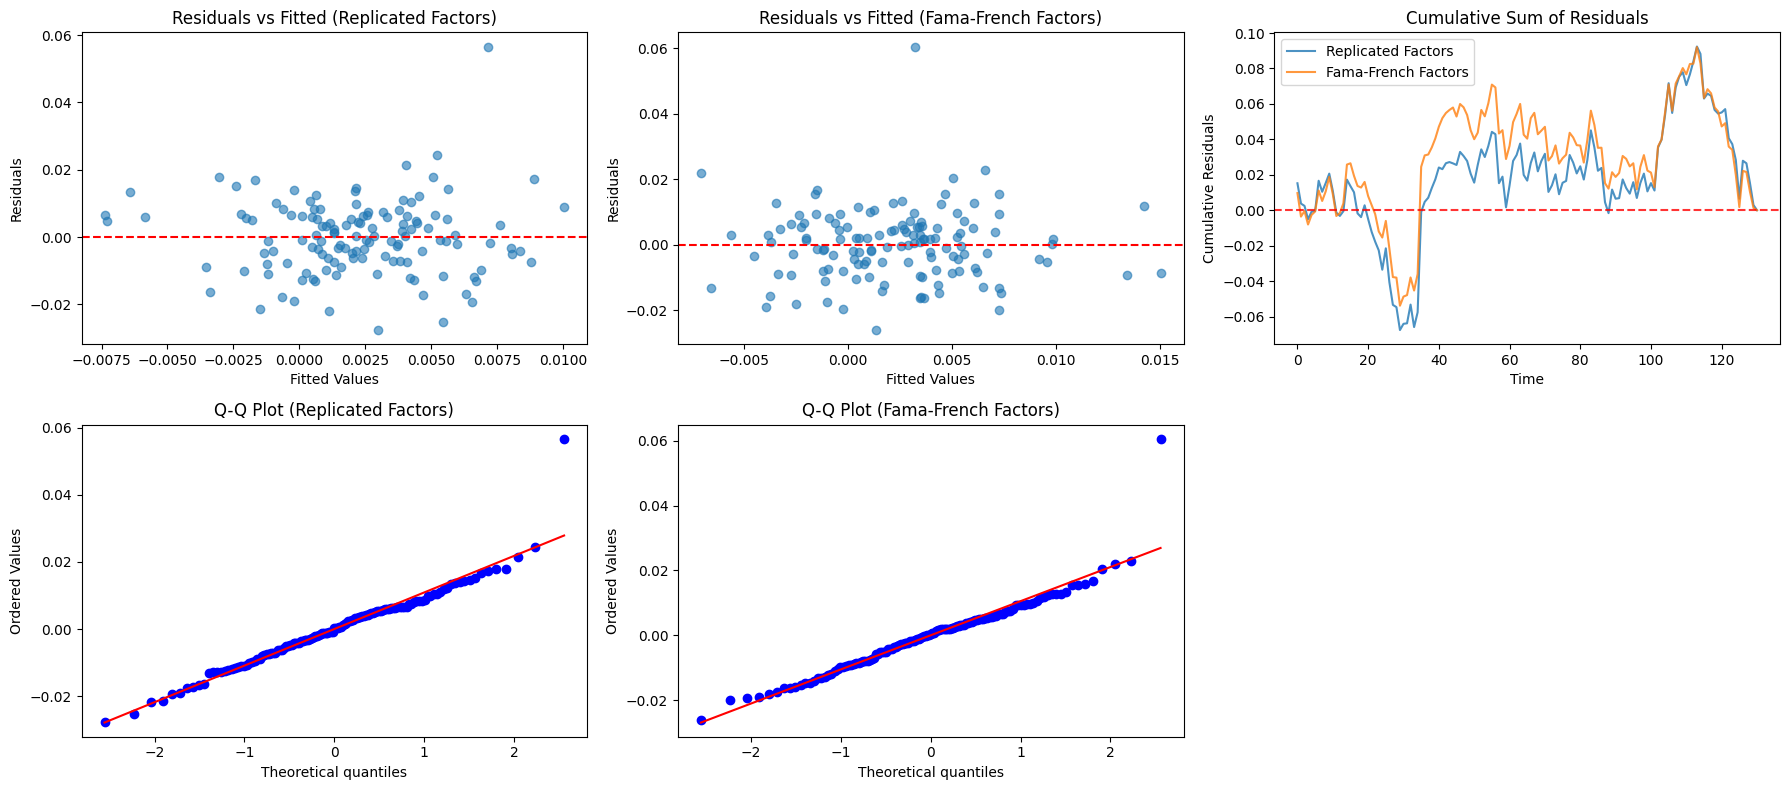


Residual Statistics:
Replicated Factors - Mean: -0.000000, Std: 0.011091
Fama-French Factors - Mean: 0.000000, Std: 0.010855


In [9]:
# Pick WMT ticker and regress on both factor sets
wmt_returns = rets['WMT'].dropna()

# Merge WMT returns with factor data
wmt_data = factors_replicated.merge(
    wmt_returns.reset_index().rename(columns={'WMT': 'wmt_return'}), 
    on='date', 
    how='inner'
).dropna()

print(f"WMT regression sample: {len(wmt_data)} observations")

# Regression on replicated factors
import statsmodels.formula.api as smf
model_wmt_replicated = smf.ols(
    formula="wmt_return ~ hml_replicated + smb_replicated + rmw_replicated + cma_replicated", 
    data=wmt_data
).fit()
print("\n=== WMT Regression on Replicated Factors ===")
display(model_wmt_replicated.summary())

# Regression on Fama-French factors
model_wmt_ff = smf.ols(
    formula="wmt_return ~ hml + smb + rmw + cma", 
    data=wmt_data
).fit()
print("\n=== WMT Regression on Fama-French Factors ===")
display(model_wmt_ff.summary())

# Plot residuals comparison
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Residuals vs fitted values
axes[0, 0].scatter(model_wmt_replicated.fittedvalues, model_wmt_replicated.resid, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted (Replicated Factors)')

axes[0, 1].scatter(model_wmt_ff.fittedvalues, model_wmt_ff.resid, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Fitted (Fama-French Factors)')

# Q-Q plots for normality
from scipy import stats
stats.probplot(model_wmt_replicated.resid, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Replicated Factors)')

stats.probplot(model_wmt_ff.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Fama-French Factors)')

# Cumulative sum of residuals on same plot
axes[0, 2].plot(np.cumsum(model_wmt_replicated.resid), label='Replicated Factors', alpha=0.8)
axes[0, 2].plot(np.cumsum(model_wmt_ff.resid), label='Fama-French Factors', alpha=0.8)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 2].set_xlabel('Time')
axes[0, 2].set_ylabel('Cumulative Residuals')
axes[0, 2].set_title('Cumulative Sum of Residuals')
axes[0, 2].legend()

# Hide the unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

# Compare residual statistics
print(f"\nResidual Statistics:")
print(f"Replicated Factors - Mean: {model_wmt_replicated.resid.mean():.6f}, Std: {model_wmt_replicated.resid.std():.6f}")
print(f"Fama-French Factors - Mean: {model_wmt_ff.resid.mean():.6f}, Std: {model_wmt_ff.resid.std():.6f}")

In [10]:
fac_returns.to_csv('fac_returns.csv')

  0%|          | 0/3236 [00:00<?, ?it/s]

Fama-French 5-Factor Model - Cross-Sectional Summary:

R-squared Statistics:
  Mean: nan
  Median: nan
  Std: nan
  Min: nan
  Max: nan

Alpha (Intercept) Statistics:
  Mean: nan
  Median: nan
  Std: nan

Beta Statistics:
  MKT-RF: Mean=nan, Std=nan
  SMB: Mean=nan, Std=nan
  HML: Mean=nan, Std=nan
  RMW: Mean=nan, Std=nan
  CMA: Mean=nan, Std=nan


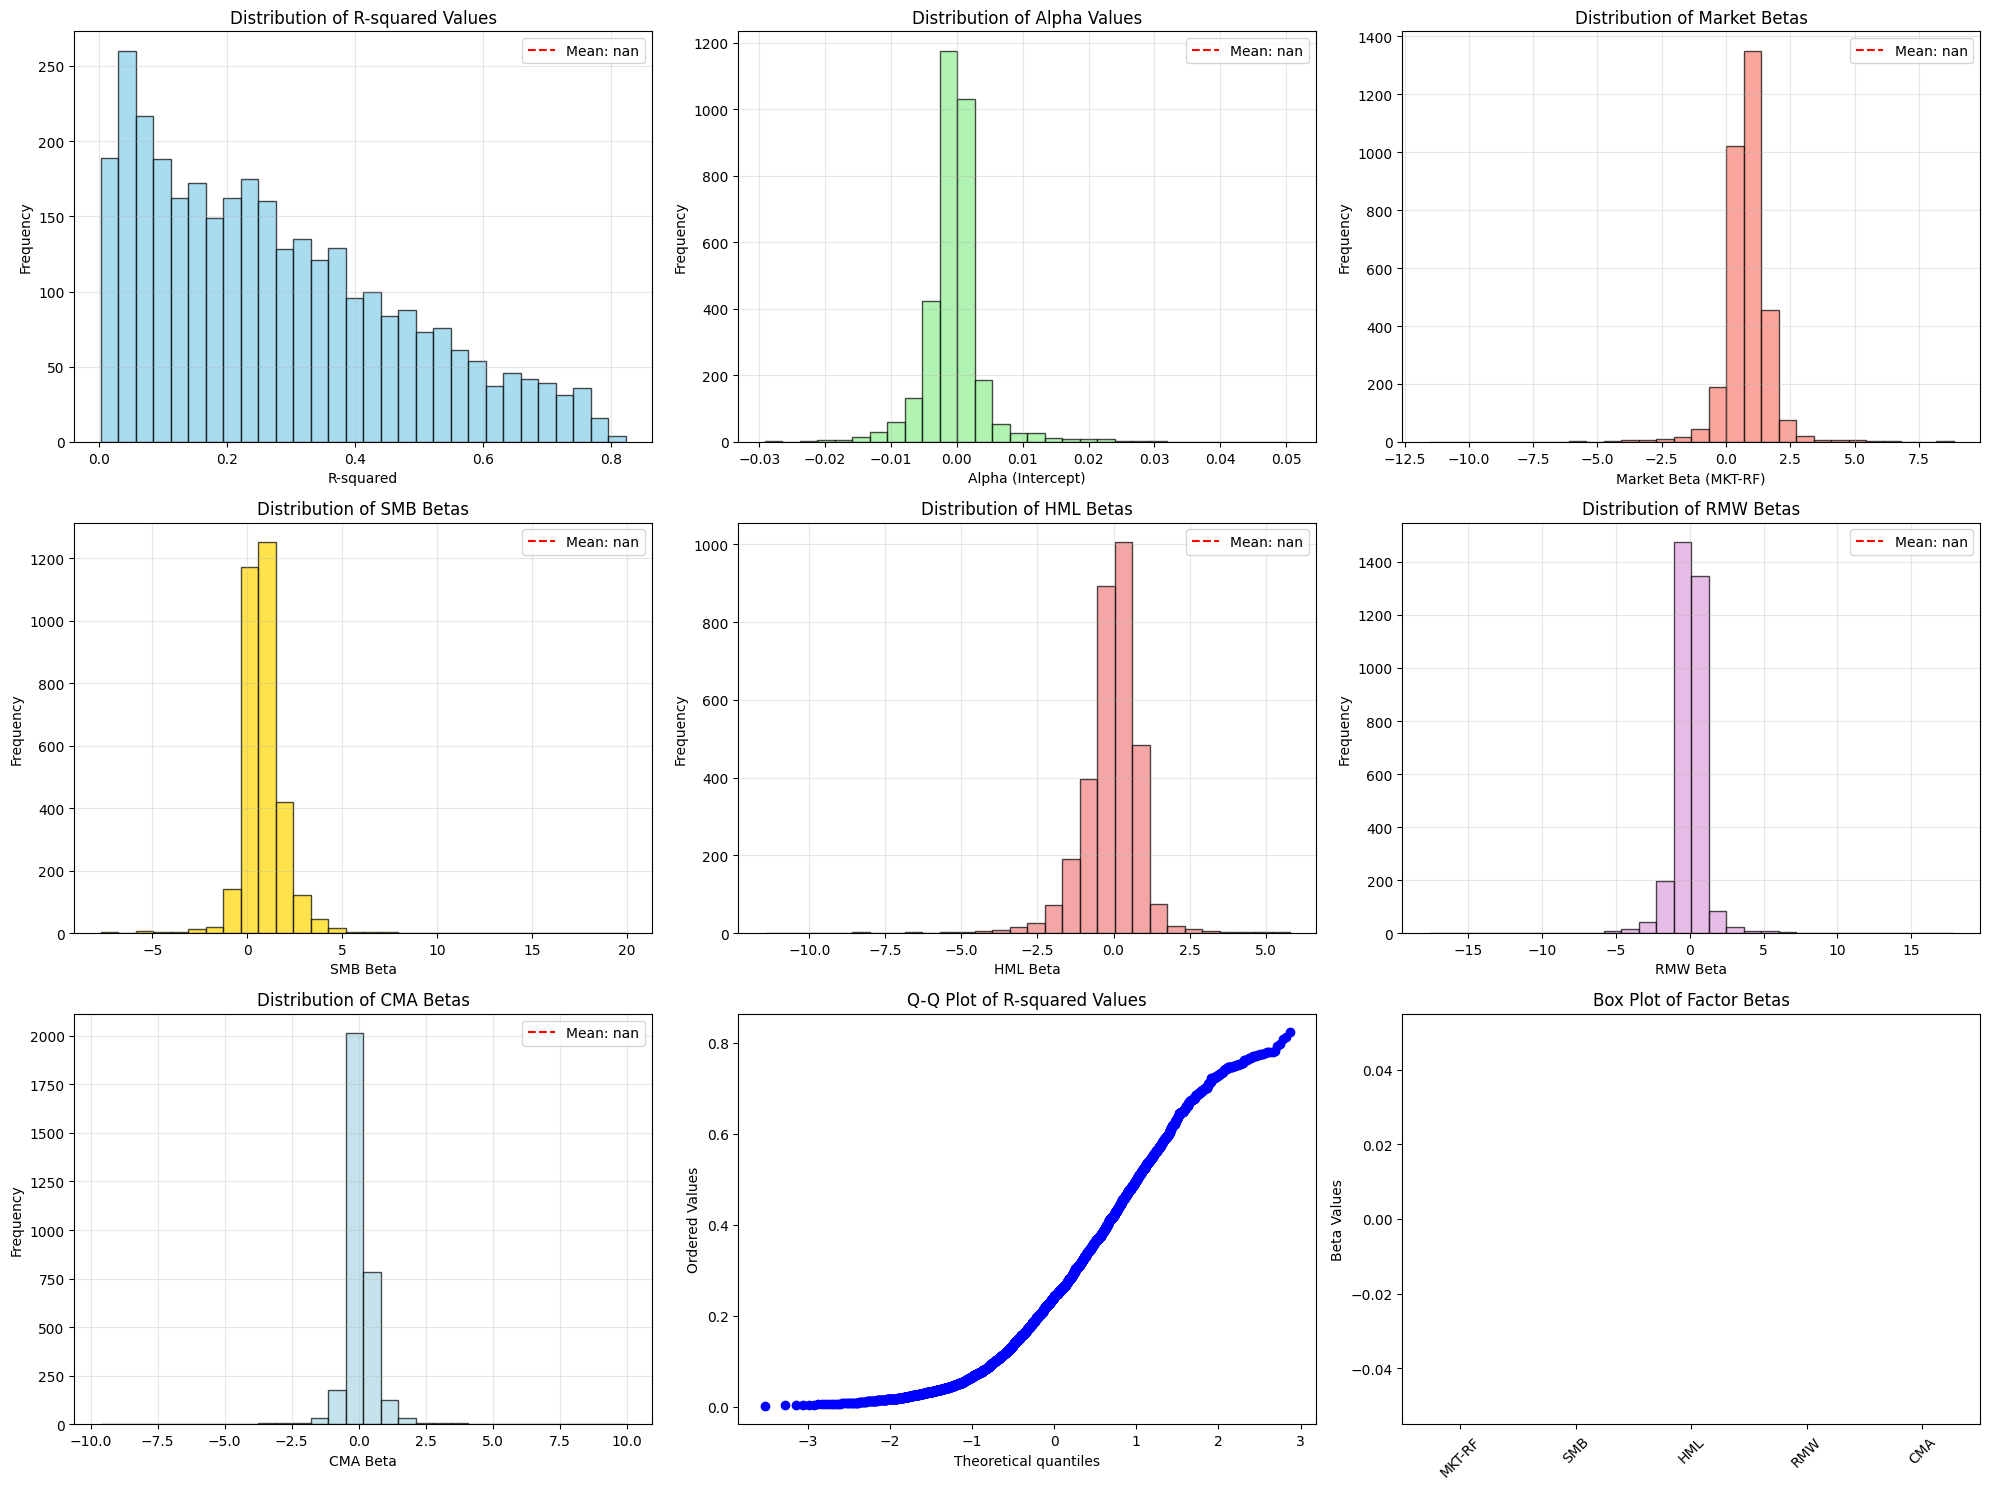


Correlation Matrix of Betas:
        MKT-RF    SMB    HML    RMW    CMA
MKT-RF   1.000 -0.359  0.596  0.139 -0.226
SMB     -0.359  1.000 -0.487  0.367  0.066
HML      0.596 -0.487  1.000  0.262 -0.085
RMW      0.139  0.367  0.262  1.000 -0.456
CMA     -0.226  0.066 -0.085 -0.456  1.000

Top 10 Stocks by R-squared:
     ticker  r_squared   alpha  mkt_beta
2949   UBSI     0.8223 -0.0001    1.4540
299    AVGO     0.8118 -0.0028    5.8391
1432   IBTX     0.8077  0.0008    1.7153
1430   IBOC     0.7964 -0.0005    1.7082
2306   PNFP     0.7919  0.0014    1.7901
535    CATY     0.7804  0.0004    1.4390
2895   TRMK     0.7797  0.0001    1.4751
2717    SSB     0.7791  0.0007    1.5626
3102   WABC     0.7786 -0.0006    1.3752
2534   SBCF     0.7781 -0.0001    1.4447

Bottom 10 Stocks by R-squared:
     ticker  r_squared   alpha  mkt_beta
908    DXCM     0.0022 -0.0029   -0.1644
756    CTAS     0.0034 -0.0104    0.5421
2104   OBLG     0.0043  0.0235    0.4468
803    CYCC     0.0044 -0.0111    0.

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Prepare data for regression - loop through all stocks
common_dates = fac_returns.index.intersection(rets.index)
X_base = fac_returns.loc[common_dates, ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']]

# Initialize lists to store results
results = []
r_squareds = []
alphas = []
betas = {'const': [], 'MKT-RF': [], 'SMB': [], 'HML': [], 'RMW': [], 'CMA': []}

# Loop through all stocks in returns
for ticker in tqdm(rets.columns):
    y = rets.loc[common_dates, ticker].dropna()
    
    # Align X with y to handle missing data
    y_aligned, X_aligned = y.align(X_base, join='inner', axis=0)
    X_aligned = sm.add_constant(X_aligned)
    
    # Only fit model if we have sufficient data
    if len(y_aligned) > 10:  # Minimum observations threshold
        model = sm.OLS(y_aligned, X_aligned).fit()
    else:
        # Create a dummy model with NaN values if insufficient data
        model = sm.OLS(y_aligned, X_aligned).fit()
        # Set all parameters to NaN
        model.params = pd.Series(index=model.params.index, dtype=float)
        model.params[:] = np.nan
        model.rsquared = np.nan
        model.rsquared_adj = np.nan
    
    # Store results
    results.append({
        'ticker': ticker,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'alpha': model.params['const'],
        'mkt_beta': model.params['MKT-RF'],
        'smb_beta': model.params['SMB'],
        'hml_beta': model.params['HML'],
        'rmw_beta': model.params['RMW'],
        'cma_beta': model.params['CMA']
    })
    
    # Store for distributions
    r_squareds.append(model.rsquared)
    alphas.append(model.params['const'])
    for factor in ['const', 'MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']:
        betas[factor].append(model.params[factor])

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print summary statistics
print("Fama-French 5-Factor Model - Cross-Sectional Summary:")
print(f"\nR-squared Statistics:")
print(f"  Mean: {np.mean(r_squareds):.4f}")
print(f"  Median: {np.median(r_squareds):.4f}")
print(f"  Std: {np.std(r_squareds):.4f}")
print(f"  Min: {np.min(r_squareds):.4f}")
print(f"  Max: {np.max(r_squareds):.4f}")

print(f"\nAlpha (Intercept) Statistics:")
print(f"  Mean: {np.mean(alphas):.6f}")
print(f"  Median: {np.median(alphas):.6f}")
print(f"  Std: {np.std(alphas):.6f}")

print(f"\nBeta Statistics:")
for factor, beta_vals in betas.items():
    if factor != 'const':
        print(f"  {factor}: Mean={np.mean(beta_vals):.4f}, Std={np.std(beta_vals):.4f}")

# Create comprehensive plots
fig = plt.figure(figsize=(20, 15))

# 1. R-squared distribution
ax1 = plt.subplot(3, 3, 1)
plt.hist(r_squareds, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(np.mean(r_squareds), color='r', linestyle='--', label=f'Mean: {np.mean(r_squareds):.3f}')
plt.xlabel('R-squared')
plt.ylabel('Frequency')
plt.title('Distribution of R-squared Values')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Alpha distribution
ax2 = plt.subplot(3, 3, 2)
plt.hist(alphas, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
plt.axvline(np.mean(alphas), color='r', linestyle='--', label=f'Mean: {np.mean(alphas):.6f}')
plt.xlabel('Alpha (Intercept)')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Values')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Market Beta distribution
ax3 = plt.subplot(3, 3, 3)
plt.hist(betas['MKT-RF'], bins=30, alpha=0.7, edgecolor='black', color='salmon')
plt.axvline(np.mean(betas['MKT-RF']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["MKT-RF"]):.3f}')
plt.xlabel('Market Beta (MKT-RF)')
plt.ylabel('Frequency')
plt.title('Distribution of Market Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. SMB Beta distribution
ax4 = plt.subplot(3, 3, 4)
plt.hist(betas['SMB'], bins=30, alpha=0.7, edgecolor='black', color='gold')
plt.axvline(np.mean(betas['SMB']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["SMB"]):.3f}')
plt.xlabel('SMB Beta')
plt.ylabel('Frequency')
plt.title('Distribution of SMB Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. HML Beta distribution
ax5 = plt.subplot(3, 3, 5)
plt.hist(betas['HML'], bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
plt.axvline(np.mean(betas['HML']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["HML"]):.3f}')
plt.xlabel('HML Beta')
plt.ylabel('Frequency')
plt.title('Distribution of HML Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. RMW Beta distribution
ax6 = plt.subplot(3, 3, 6)
plt.hist(betas['RMW'], bins=30, alpha=0.7, edgecolor='black', color='plum')
plt.axvline(np.mean(betas['RMW']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["RMW"]):.3f}')
plt.xlabel('RMW Beta')
plt.ylabel('Frequency')
plt.title('Distribution of RMW Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 7. CMA Beta distribution
ax7 = plt.subplot(3, 3, 7)
plt.hist(betas['CMA'], bins=30, alpha=0.7, edgecolor='black', color='lightblue')
plt.axvline(np.mean(betas['CMA']), color='r', linestyle='--', label=f'Mean: {np.mean(betas["CMA"]):.3f}')
plt.xlabel('CMA Beta')
plt.ylabel('Frequency')
plt.title('Distribution of CMA Betas')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Q-Q plot for R-squared (to check normality)
ax8 = plt.subplot(3, 3, 8)
stats.probplot(r_squareds, dist="norm", plot=plt)
plt.title('Q-Q Plot of R-squared Values')

# 9. Box plot of all betas
ax9 = plt.subplot(3, 3, 9)
beta_data = [betas['MKT-RF'], betas['SMB'], betas['HML'], betas['RMW'], betas['CMA']]
beta_labels = ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA']
box = plt.boxplot(beta_data, labels=beta_labels, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)
plt.title('Box Plot of Factor Betas')
plt.ylabel('Beta Values')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation matrix of betas
beta_df = pd.DataFrame(betas)
beta_corr = beta_df.drop('const', axis=1).corr()
print(f"\nCorrelation Matrix of Betas:")
print(beta_corr.round(3))

# Top 10 stocks by R-squared
top_r2 = results_df.nlargest(10, 'r_squared')[['ticker', 'r_squared', 'alpha', 'mkt_beta']]
print(f"\nTop 10 Stocks by R-squared:")
print(top_r2.round(4))

# Bottom 10 stocks by R-squared
bottom_r2 = results_df.nsmallest(10, 'r_squared')[['ticker', 'r_squared', 'alpha', 'mkt_beta']]
print(f"\nBottom 10 Stocks by R-squared:")
print(bottom_r2.round(4))

# Save results to DataFrame for further analysis
print(f"\nFull results saved to results_df with shape: {results_df.shape}")


Running cointegration tests on cumulative returns for all equities... (this may take a while)


Cointegration Tests:   0%|          | 0/3236 [00:00<?, ?it/s]


Cointegration Test Results (on Cumulative Returns):
Total equities tested: 3224
Cointegrated equities: 368
Percentage cointegrated: 11.41%


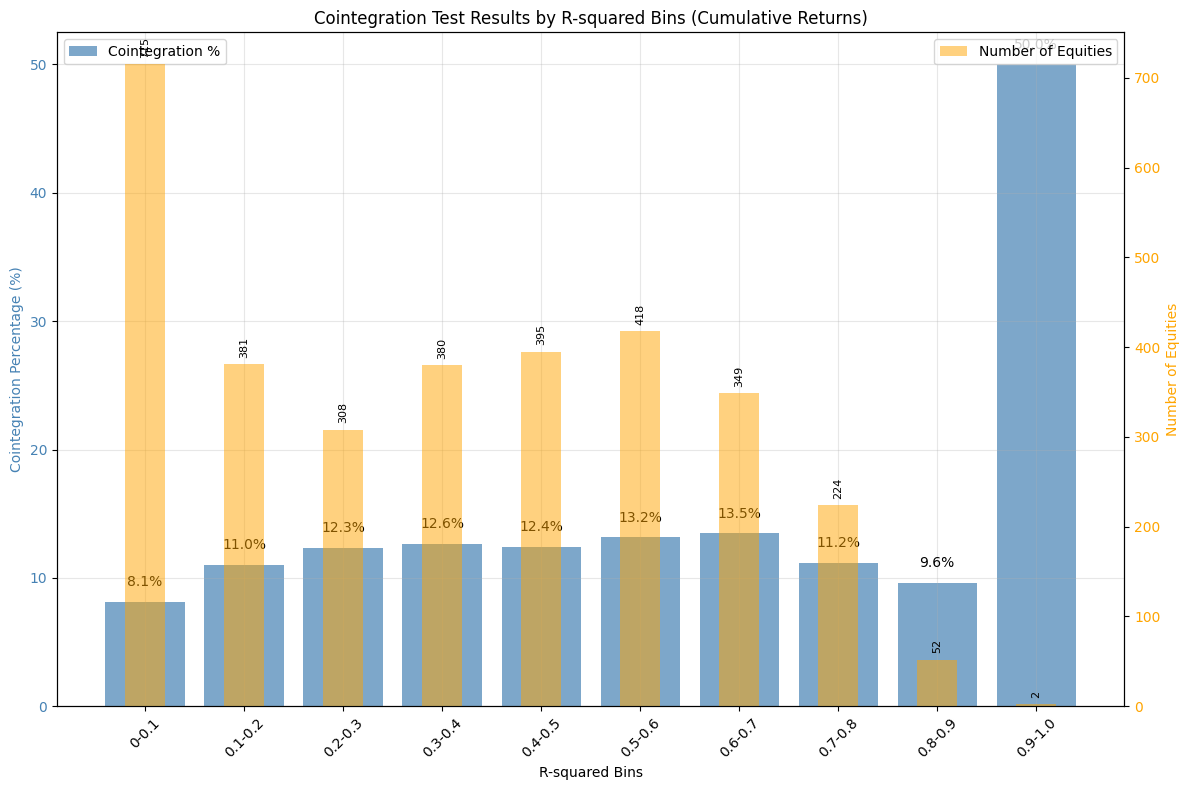


Detailed Bin Analysis:
 R2_Bin  Num_Equities  Cointegrated Percentage
  0-0.1           715            58      8.11%
0.1-0.2           381            42     11.02%
0.2-0.3           308            38     12.34%
0.3-0.4           380            48     12.63%
0.4-0.5           395            49     12.41%
0.5-0.6           418            55     13.16%
0.6-0.7           349            47     13.47%
0.7-0.8           224            25     11.16%
0.8-0.9            52             5      9.62%
0.9-1.0             2             1     50.00%

Cointegration results saved to cointegration_df with shape: (3224, 7)


In [12]:
from scipy.stats import chi2
from tqdm.auto import tqdm
import warnings
import numpy as np  # Assuming np is imported; add if not
import pandas as pd  # Assuming pd is imported; add if not
import statsmodels.api as sm  # Assuming sm is imported; add if not
import matplotlib.pyplot as plt  # Assuming plt is imported; add if not

warnings.filterwarnings('ignore')

# Compute cumulative sums (integrated returns, approximating price levels)
# Assuming rets and fac_returns are DataFrames with excess returns
cum_rets = rets.cumsum()  # Cumulative stock returns
cum_fac = fac_returns['MKT-RF'].cumsum()  # Cumulative market returns

# Perform Engle-Granger cointegration test for each equity against market
cointegration_results = []
r2_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
              '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

# Initialize counters for bin analysis
bin_cointegrated = np.zeros(len(r2_bins)-1)
bin_total = np.zeros(len(r2_bins)-1)

print("Running cointegration tests on cumulative returns for all equities... (this may take a while)")
for ticker in tqdm(rets.columns, desc="Cointegration Tests"):
    try:
        y = cum_rets.loc[common_dates, ticker].dropna()
        x = cum_fac.loc[common_dates].reindex(y.index).dropna()
        
        # Align data
        common_idx = y.index.intersection(x.index)
        if len(common_idx) < 30:  # Skip if too few observations
            continue
            
        y_aligned = y.loc[common_idx]
        x_aligned = x.loc[common_idx]
        
        # Skip if still not enough data
        if len(y_aligned) < 30:
            continue
            
        # First stage: OLS regression of cumulative stock returns on cumulative market
        X_reg = sm.add_constant(x_aligned)
        model1 = sm.OLS(y_aligned, X_reg).fit()
        residuals = model1.resid
        
        # Second stage: ADF test on residuals
        adf_result = sm.tsa.stattools.adfuller(residuals, regression='c', autolag='AIC')
        adf_stat = adf_result[0]
        p_value = adf_result[1]
        
        # Critical values for cointegration test (Engle-Granger)
        n_obs = len(residuals)
        if n_obs <= 50:
            crit_90 = -3.37
            crit_95 = -3.67
            crit_99 = -4.21
        elif n_obs <= 100:
            crit_90 = -3.27
            crit_95 = -3.57
            crit_99 = -4.11
        elif n_obs <= 250:
            crit_90 = -3.13
            crit_95 = -3.43
            crit_99 = -3.96
        else:
            crit_90 = -3.04
            crit_95 = -3.34
            crit_99 = -3.88
        
        # Determine if cointegrated (reject null of unit root)
        cointegrated = (adf_stat < crit_95)  # Using 5% significance level
        
        # Get R-squared from first stage regression (now on cumsums, so measures long-run fit)
        r_squared = model1.rsquared
        
        # Store results
        cointegration_results.append({
            'ticker': ticker,
            'r_squared': r_squared,
            'adf_stat': adf_stat,
            'adf_p_value': p_value,
            'n_obs': n_obs,
            'cointegrated': cointegrated,
            'crit_95': crit_95
        })
        
        # Update bin counters
        if not np.isnan(r_squared):
            bin_idx = np.digitize(r_squared, r2_bins) - 1
            if 0 <= bin_idx < len(bin_total):
                bin_total[bin_idx] += 1
                if cointegrated:
                    bin_cointegrated[bin_idx] += 1
                    
    except Exception as e:
        # Skip problematic tickers
        continue

# Convert to DataFrame
cointegration_df = pd.DataFrame(cointegration_results)

# Overall statistics
total_equities = len(cointegration_df)
cointegrated_count = cointegration_df['cointegrated'].sum()
cointegration_percentage = (cointegrated_count / total_equities) * 100 if total_equities > 0 else 0

print(f"\nCointegration Test Results (on Cumulative Returns):")
print(f"Total equities tested: {total_equities}")
print(f"Cointegrated equities: {cointegrated_count}")
print(f"Percentage cointegrated: {cointegration_percentage:.2f}%")

# Bin analysis
bin_percentages = []
for i in range(len(bin_total)):
    if bin_total[i] > 0:
        percentage = (bin_cointegrated[i] / bin_total[i]) * 100
    else:
        percentage = 0
    bin_percentages.append(percentage)

# Create visualization
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for cointegration percentage by R-squared bin
bars1 = ax1.bar(range(len(bin_labels)), bin_percentages, 
                color='steelblue', alpha=0.7, label='Cointegration %')
ax1.set_xlabel('R-squared Bins')
ax1.set_ylabel('Cointegration Percentage (%)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(range(len(bin_labels)))
ax1.set_xticklabels(bin_labels, rotation=45)
ax1.set_title('Cointegration Test Results by R-squared Bins (Cumulative Returns)')
ax1.grid(True, alpha=0.3)

# Twin y-axis for number of equities per bin
ax2 = ax1.twinx()
bars2 = ax2.bar(range(len(bin_labels)), bin_total, 
                color='orange', alpha=0.5, width=0.4, label='Number of Equities')
ax2.set_ylabel('Number of Equities', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add value labels on bars
max_n = max(bin_total) if len(bin_total) > 0 else 1
for i, (p, n) in enumerate(zip(bin_percentages, bin_total)):
    if n > 0:
        ax1.text(i, p + 1, f'{p:.1f}%', ha='center', va='bottom')
    ax2.text(i, n + max_n * 0.01, f'{int(n)}', ha='center', va='bottom', 
             rotation=90, fontsize=8)

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Summary table
print(f"\nDetailed Bin Analysis:")
summary_data = []
for i, label in enumerate(bin_labels):
    if bin_total[i] > 0:
        pct = bin_percentages[i]
        summary_data.append({
            'R2_Bin': label,
            'Num_Equities': int(bin_total[i]),
            'Cointegrated': int(bin_cointegrated[i]),
            'Percentage': f"{pct:.2f}%"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save results
print(f"\nCointegration results saved to cointegration_df with shape: {cointegration_df.shape}")